[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

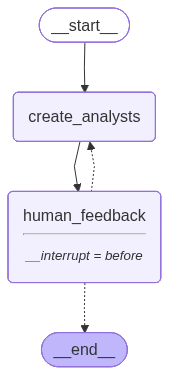

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 4 
topic = "Royal Challengers Bangalore (RCB) IPL 2024 season — strategic analysis"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Rahul Mehta
Affiliation: ESPN Cricinfo
Role: Team Performance Analyst
Description: Rahul focuses on analyzing the on-field performance of RCB players. His primary concern is to identify strengths and weaknesses in the team's playing strategy, player form, and match tactics. He aims to provide insights that can help RCB optimize their game plans for the 2024 IPL season.
--------------------------------------------------
Name: Anjali Kapoor
Affiliation: The Economic Times
Role: Financial Analyst
Description: Anjali examines the financial strategies of RCB, including player acquisitions, sponsorship deals, and revenue streams. Her focus is on understanding how RCB can maximize their financial performance while maintaining a competitive team. She is particularly interested in the economic impact of player trades and the financial sustainability of the franchise.
--------------------------------------------------
Name: Vikram Singh
Affiliation: CricBuzz
Role: Fan Engagement Specialist

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add a statistician focusing on run rates and death-overs performance"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b8ef1-1c2b-64ac-8002-212880bba232'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Rahul Mehta
Affiliation: ESPN Cricinfo
Role: Team Performance Analyst
Description: Rahul focuses on analyzing the on-field performance of RCB players. His primary concern is to identify strengths and weaknesses in the team's playing strategy, player form, and match tactics. He aims to provide insights that can help RCB optimize their game plans for the 2024 IPL season.
--------------------------------------------------
Name: Anjali Kapoor
Affiliation: The Economic Times
Role: Financial Analyst
Description: Anjali examines the financial strategies of RCB, including player acquisitions, sponsorship deals, and revenue streams. Her focus is on understanding how RCB can maximize their financial performance while maintaining a competitive team. She is particularly interested in the economic impact of player trades and the financial sustainability of the franchise.
--------------------------------------------------
Name: Vikram Singh
Affiliation: CricBuzz
Role: Fan Engagement Specialist

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b8ef1-5391-6716-8004-36465813cb3a'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Rajesh Kumar
Affiliation: Cricket Analytics Institute
Role: Statistician
Description: Rajesh focuses on analyzing RCB's run rates and performance during death overs. He is particularly interested in how the team can optimize their scoring in the final overs of the innings and how they can improve their bowling strategies to restrict opponents during the same period.
--------------------------------------------------
Name: Anita Desai
Affiliation: Sports Strategy Group
Role: Team Dynamics Specialist
Description: Anita examines the internal dynamics of the RCB team, including player roles, leadership impact, and team morale. Her analysis aims to identify how these factors influence on-field performance and how they can be optimized for better results.
--------------------------------------------------
Name: Vikram Singh
Affiliation: Cricket Performance Lab
Role: Player Development Analyst
Description: Vikram is dedicated to assessing the development and performance of individual pl

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [16]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [17]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [18]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [19]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15480\2675700386.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

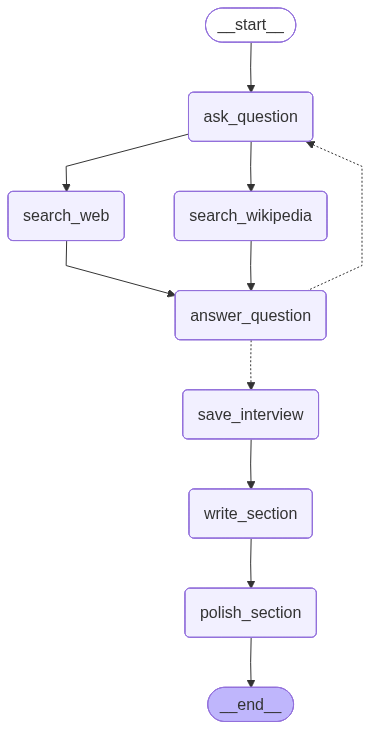

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search (robust to missing API key / network)
    try:
        search_docs = tavily_search.invoke(search_query.search_query)
    except Exception:
        search_docs = []

    # Format
    if not search_docs:
        formatted_search_docs = ""
    else:
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search (robust)
    try:
        search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()
    except Exception:
        search_docs = []

    # Format
    if not search_docs:
        formatted_search_docs = ""
    else:
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
                for doc in search_docs
            ]
        )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    """ Node to answer a question """
    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state.get("context", [])

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """ Save interviews """
    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):
    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
 a. Title (## header)
 b. Summary (### header)
 c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """ Node to answer a question """
    # Get state
    interview = state["interview"]
    context = state.get("context", [])
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

def polish_section(state: InterviewState):
    """Post-process the section text and replace it in-place."""
    sections = state.get("sections", [])
    if sections:
        polished = sections[-1] + "\n\n-- End of Section --"
        return {"sections": [polished]}
    return {}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)
interview_builder.add_node("polish_section", polish_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", "polish_section")
interview_builder.add_edge("polish_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Cricket Analytics Institute', name='Rajesh Kumar', role='Statistician', description="Rajesh focuses on analyzing RCB's run rates and performance during death overs. He is particularly interested in how the team can optimize their scoring in the final overs of the innings and how they can improve their bowling strategies to restrict opponents during the same period.")

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [23]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Optimizing RCB's Death Overs: Strategies for Success

### Summary

The Royal Challengers Bangalore (RCB) have consistently faced challenges in the Indian Premier League (IPL), particularly during the death overs, which are the final overs of a cricket match. These overs are crucial as they often determine the outcome of the game. RCB's performance in these overs has been a focal point for analysts, including Rajesh, who is keen on understanding how the team can enhance their scoring and restrict opponents effectively during this period.

RCB's struggles in the death overs are not isolated to either batting or bowling but are a combination of both. On the bowling front, RCB has been unable to contain runs effectively, as highlighted in their match against Kolkata Knight Riders (KKR), where their vulnerabilities were exposed [1]. This inability to restrict runs during the death overs has been a recurring issue, contributing to their position at the bottom of the IPL standings in 2024 [2].

From a batting perspective, the strategy during the death overs involves selecting players with high strike rates who can capitalize on the smaller ground dimensions, such as those at Chinnaswamy Stadium in Bangalore [3]. This approach can significantly boost the team's scoring potential in the final overs.

Interestingly, the use of aggressive fielding strategies during the death overs can also play a pivotal role. By spreading fielders across the boundary and maintaining some close to the batsman, RCB can create pressure and potentially induce mistakes from the opposition [4]. Additionally, employing bowlers with a proven track record in the death overs, who can deliver yorkers and slower balls effectively, is crucial for taking wickets and minimizing runs [5].

The insights gathered suggest that RCB needs to focus on a balanced approach that combines strategic batting, effective bowling, and dynamic fielding to optimize their performance during the death overs. By addressing these areas, RCB can improve their chances of success in future IPL seasons.

### Sources
[1] https://sportsmanbazar.com/blogs/news/rcb-s-bowling-struggles-why-they-re-ipl-2024-s-bottom-team?srsltid=AfmBOopOCT_opmv1OpQ9RjrOy9hRxBeIBM3sSKLg17uSHfKFphFkvJPT  
[2] https://www.reddit.com/r/RCB/comments/1g8ntej/part_2_looking_back_at_2024/  
[3] https://fantasycricketkamastermind.beehiiv.com/p/powerplay-vs-death-overs-how-to-maximize-your-dream11-fantasy-points-in-ipl-2025  
[4] https://www.neweratraining.net/cricket-fielding-positions/  
[5] https://btnutra.com/blog/f/cricket-strategies-for-t20-leagues-winning-tips?srsltid=AfmBOooZTBvWsJs-xlkkH7nouqD7EInRzXsRYyicR4O9BJrPqic1ZHKC  

-- End of Section --

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

C:\Users\Admin\AppData\Local\Temp\ipykernel_15480\3790429458.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


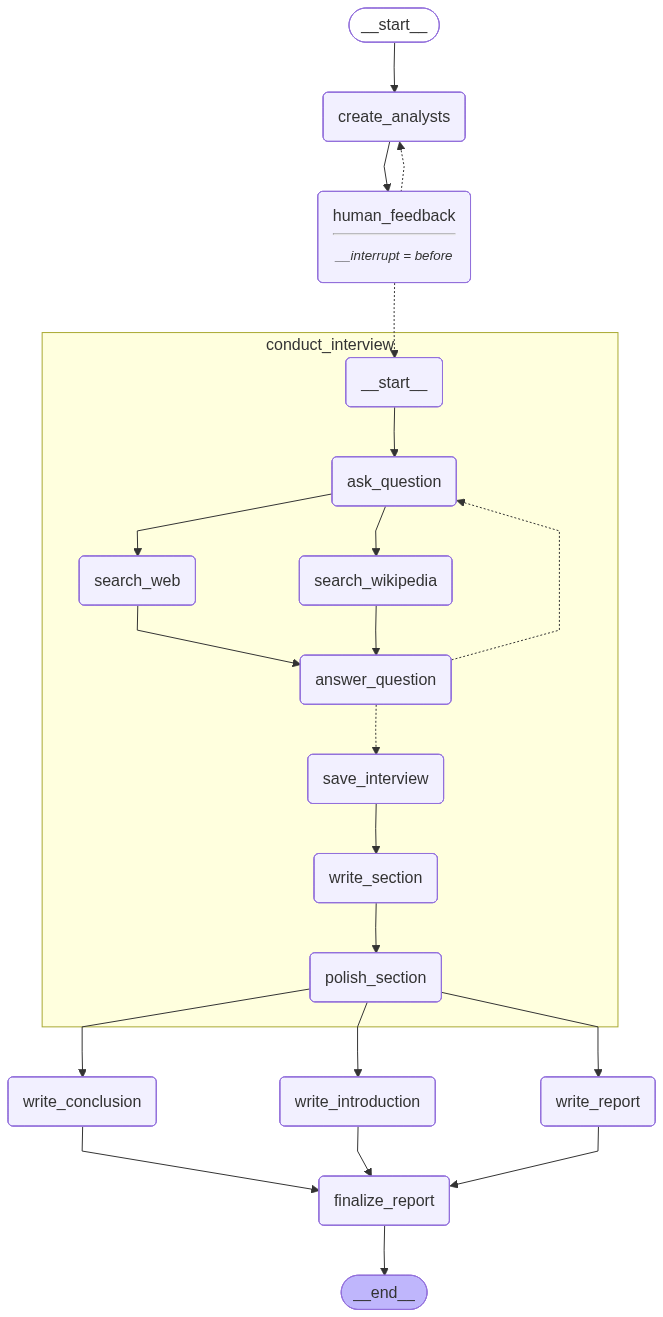

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 4 
topic = "Royal Challengers Bangalore (RCB) IPL 2024 season — strategic analysis"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Rahul Mehta
Affiliation: ESPN Cricinfo
Role: Team Performance Analyst
Description: Rahul focuses on analyzing the on-field performance of RCB players. His primary concern is to identify strengths and weaknesses in the team's gameplay, including batting, bowling, and fielding strategies. He aims to provide insights that can help RCB improve their match-winning capabilities.
--------------------------------------------------
Name: Anita Kapoor
Affiliation: Sports Business Journal
Role: Financial Analyst
Description: Anita examines the financial aspects of RCB's IPL 2024 season. Her analysis includes sponsorship deals, player salaries, and overall team profitability. She is interested in understanding how financial decisions impact team performance and long-term sustainability.
--------------------------------------------------
Name: Vikram Singh
Affiliation: The Hindu
Role: Fan Engagement Specialist
Description: Vikram studies RCB's fan engagement strategies, both online and offlin

In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b8ef4-cd89-6146-8002-3023a8d0a070'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Rahul Mehta
Affiliation: ESPN Cricinfo
Role: Team Performance Analyst
Description: Rahul focuses on analyzing the on-field performance of RCB players. His primary concern is to identify strengths and weaknesses in the team's gameplay, including batting, bowling, and fielding strategies. He aims to provide insights that can help RCB improve their match-winning capabilities.
--------------------------------------------------
Name: Anita Kapoor
Affiliation: Sports Business Journal
Role: Financial Analyst
Description: Anita examines the financial aspects of RCB's IPL 2024 season. Her analysis includes sponsorship deals, player salaries, and overall team profitability. She is interested in understanding how financial decisions impact team performance and long-term sustainability.
--------------------------------------------------
Name: Vikram Singh
Affiliation: The Hindu
Role: Fan Engagement Specialist
Description: Vikram studies RCB's fan engagement strategies, both online and offlin

In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b8ef5-17f3-61c2-8004-eba0634d2076'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Strategic Insights into RCB's IPL 2024 Season

## Introduction

The Royal Challengers Bangalore (RCB) have consistently been a team of high potential in the Indian Premier League (IPL), yet their quest for the championship title remains unfulfilled. This report provides a strategic analysis of RCB's 2024 season, examining key areas such as player retention, game plans, and in-game tactics. It highlights the leadership dynamics under Faf du Plessis and Virat Kohli, the impact of AI in sports analytics, and the innovative fan engagement strategies that have bolstered RCB's brand. By synthesizing these insights, the report aims to offer a comprehensive understanding of RCB's strategic maneuvers and their implications for future success.

---



The Royal Challengers Bangalore (RCB) have been a team of great potential in the Indian Premier League (IPL), yet they have often struggled to secure the championship title. As the 2024 season approaches, a strategic analysis reveals several key insights that could enhance RCB's performance and fan engagement.

A critical aspect of team strategy is the optimization of player performance through advanced metrics and AI technologies. Traditional statistics are now being supplemented with adjusted batting scores and the Combined Bowling Rate (CBR) for a more nuanced analysis, allowing for fairer comparisons of players [2]. AI technologies are transforming decision-making processes by analyzing vast datasets to identify patterns and trends, enabling data-driven decisions such as team lineup formations and match outcome predictions [1]. AI tools like Fulltrack provide pro-grade performance data and auto-clipped video highlights, optimizing player performance reviews [2]. Moreover, AI's predictive capabilities extend to injury management, allowing for early intervention and personalized training modifications [4].

RCB's strategic decisions in player retention and auction strategies have been contentious, particularly the retention of aging superstars like Andre Russell and Sunil Narine despite declining performances [1]. Leadership under Virat Kohli has been both a strength and a challenge, with decision-making in high-pressure situations often questioned [2]. However, the team's resilience and ability to secure a playoff spot despite initial setbacks highlight their potential [3].

Home advantage remains a significant factor, providing psychological and physiological benefits that can be leveraged for better performance [4]. Additionally, understanding player "hot streaks" can help strategize better in crucial matches [3].

RCB's fan engagement strategies have been aggressive and multifaceted, focusing on digital platforms to enhance brand visibility and deepen fan engagement. Their social media presence leads the IPL buzz, with targeted campaigns that resonate with fans [2]. Community outreach through initiatives like "RCB Cares" aims to create safe environments and support local talent, enhancing brand image and building a loyal fan base [3][4].

In conclusion, RCB's strategic focus for the 2024 IPL season should integrate advanced performance metrics, AI technologies, and comprehensive fan engagement strategies. By leveraging these insights, RCB can optimize their strategies, enhance their chances of success, and maintain a competitive edge in the IPL.


---

## Conclusion

The Royal Challengers Bangalore's IPL 2024 season was a testament to the intricate balance of strategy, leadership, and innovation. Despite initial setbacks, RCB's resurgence into the playoffs highlighted the impact of strategic leadership and key player performances. However, contentious decisions in player retention and auction strategies underscored the need for refined foresight. The integration of AI in sports analytics offered RCB a competitive edge, enhancing decision-making and fan engagement. Meanwhile, RCB's robust marketing and community outreach efforts fortified their brand, turning challenges into a unique identity. As RCB looks ahead, these insights will be crucial in shaping future successes.

## Sources
[1] https://www.iplt20.com/stats/2024  
[2] https://ijcaonline.org/archives/volume186/number30/patel-2024-ijca-923882.pdf  
[3] https://arxiv.org/html/2401.15161v1  
[4] https://en.wikipedia.org/wiki/Home_advantage  
[5] https://www.jetir.org/papers/JETIR2506016.pdf  
[6] https://danweston.substack.com/p/ipl-retentions-team-analysis  
[7] https://m.economictimes.com/news/sports/ipl-2024-sunil-gavaskar-terms-rcbs-performance-absolutely-phenomenal/articleshow/110340077.cms  
[8] https://bostoninstituteofanalytics.org/blog/the-impact-of-machine-learning-on-ipl-performance-forecasting/  
[9] https://www.fulltrack.ai/  
[10] https://digitaldefynd.com/IQ/ai-use-in-cricket/  
[11] https://www.americaspg.com/article/pdf/3818  
[12] https://medium.com/@jeyadev_needhi/ipl-2-0-the-ai-version-transforming-cricket-with-artificial-intelligence-2eec10f1c627  
[13] https://homeschoolofbusiness.substack.com/p/royal-challengers-bangaloreipl-case  
[14] https://www.storyboard18.com/brand-makers/business-of-belief-what-rcbs-ipl-win-means-for-sports-branding-68758.htm  
[15] https://www.tribuneindia.com/news/sports/rcb-announces-framework-for-rcb-cares-focused-on-fan-safety-and-community-development/  
[16] https://www.royalchallengers.com/rcb-cricket-news/news/rcb-cares-a-promise-to-support-empower-and-elevate-the-12th-man-army

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r